In [3]:
%matplotlib inline
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from models_script import RegEffectModel
from sklearn.model_selection import train_test_split

# Load Data

In [4]:
# read the data
ratings_df = pd.read_csv('raw/ml-100k/u.data', sep = '\t', header = None, 
                      names = ['user_id', 'movie_id', 'rating', 'timestamp'])
ratings_df['timestamp'] = ratings_df['timestamp'].apply(datetime.fromtimestamp)

# SGD

## Step 1. Matrix factorization (Singular value decompostion)

Shown in the following figure, a rating matrix is decomposed as a user matrix (denote as $p$) and an item matrix (denote as $q$) by SVD.

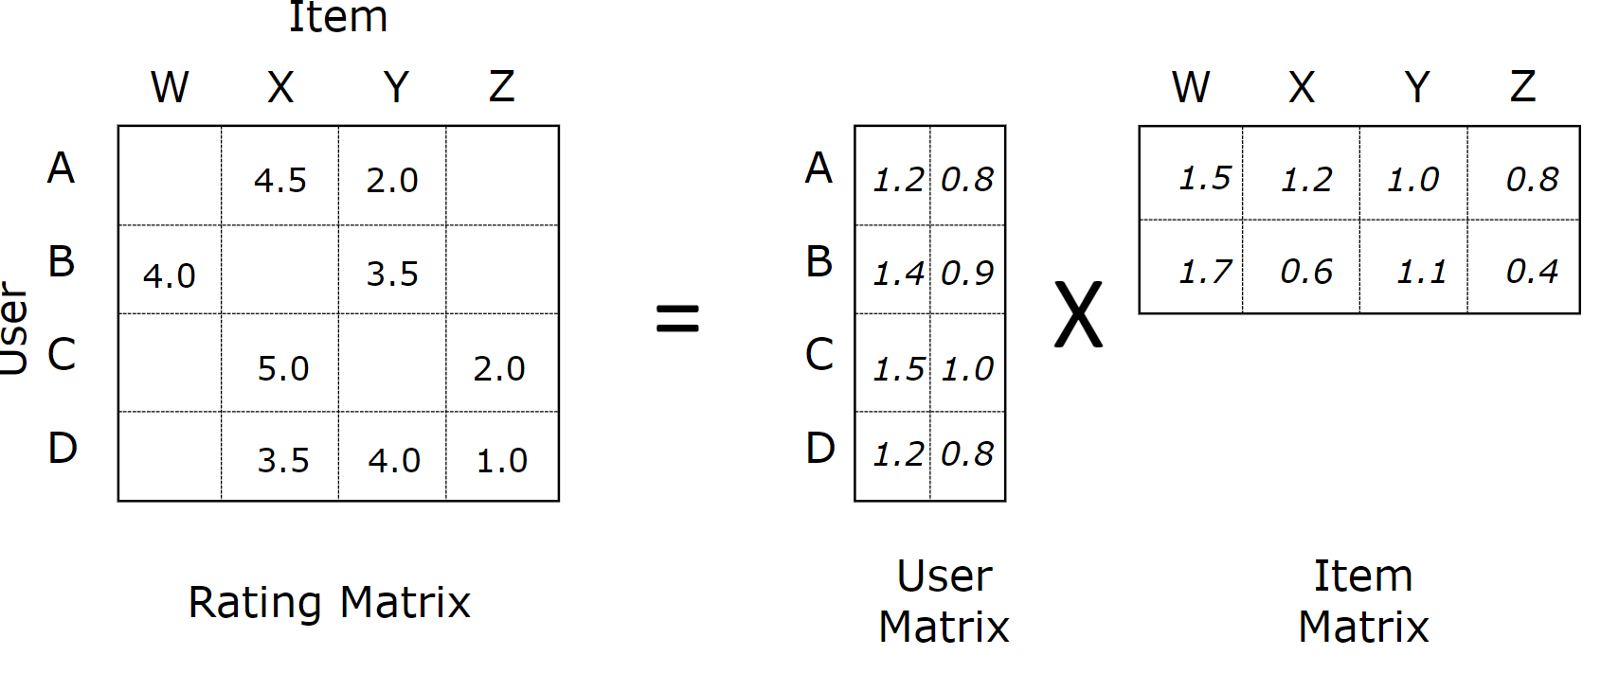

In [3]:
Image(filename='svd.png')

Mathematically,

$$R = P^T \cdot Q$$

Where, 


$R$ is the rating matrix

$P$ is the user matrix with dimension $n\times k$, $n$ is number of users and $k$ is number of features

$Q$ is the item matrix with dimension $k\times m$, $m$ is number of movie and $k$ is number of features


In the estimated $R$ matrix, the predicted rating score of movie $i$ by user $u$ is:

$$\hat{r}_{ui} =  p_u^T \cdot q_i$$

The estimation error is defined as:

$$e_{ui} = r_{ui} - \hat{r}_{ui}$$

## Step 2. Optimizing parameters  by stochastic gradient descent (SGD)

Much of the observed variation in rating values is due to effects associated with either users or items, known as biases or intercepts, independent of any interactions. For example, typical collaborative filtering data exhibits large systematic tendencies for some users to give higher ratings than others, and for some items to receive higher ratings than others. After all, some products are widely perceived as better (or worse) than others.

Thus, it would be unwise to explain the full rating value by an interaction of the form $q_i^Tp_u$. Instead, the system tries to identify the portion of these values that individual user or item biases can explain, subjecting only the true interaction portion of the data to factor modeling. A first-order approximation of the bias involved in rating $r_{ui}$ is as follows:


$$b_{ui} = u + b_i + b_u$$

$$\hat{r}_{ui} = b_{ui} + p_u^T \cdot q_i = \mu + b_u + b_i + p_u^T \cdot q_i$$


Where,

$b_{ui}$  is the bias of user $u$ for movie $i$

$\mu$ is the overall average rating score,

$b_u$ is the bias of user $u$ and $b_i$ is the bias of movie $i$.



The loss function, with penality foroverfitting, is introduced:
$$
L = \sum_{u,i}(r_{ui} - \hat{r}_{ui})^2 +
  \lambda_{b_u} \sum_u \lVert b_u \lVert^2 +
  \lambda_{b_i} \sum_i \lVert b_i \lVert^2 +
  \lambda_{p_u} \sum_u \lVert \mathbf{p}_u \lVert^2 +
  \lambda_{q_i} \sum_i \lVert \mathbf{q}_i \lVert^2
$$


SGD is used to seek for optimal parameters that minimize the loss function. The proof can be found for [here](https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea#d42b). In each iteration, $b_u$, $b_i$, $p_u$, $q_i$ will be updated:

$$
b_u^{t+1} = b_u^{t} + \eta (e_{ui} - \lambda_{b_u}b_u) \\
b_i^{t+1} = b_i^{t} + \eta (e_{ui} - \lambda_{b_i}b_i) \\
\mathbf{p}_u^{t+1} = \mathbf{p}_u^{t} + \eta (e_{ui} \mathbf{q}_i - \lambda_{p_u} \mathbf{p}_u) \\
\mathbf{q}_i^{t+1} = \mathbf{q}_i^{t} + \eta (e_{ui} \mathbf{p}_u - \lambda_{q_i} \mathbf{q}_i) \\
$$

where $\eta$ is the learning rate (a parameter that controls the speed of descent down the gradients) and $e_{ui}$ is the prediction error given by $r_{ui} - \hat{r}_{ui}$.


After certain iterations, it is possible to get optimal $b_u$, $b_i$, $p_u$, $q_i$. Thus, for each $u$ and $i$, we are able to estimate the predicted rating. The performance is evaluated by RMSE:

$$RMSE = \sqrt{\frac{1}{n} \sum_{i = 1}^{n}(r_{i} - \hat{r}_{i})^2}$$

Where 

$r_i$ is the true rating score;  $\hat{r}_{i}$ is the predicted rating score.

# SGD

In [5]:
from models_script import RegEffectModel

In [6]:
def RMSE(pred_val, true_val):
    
    return np.sqrt(mean_squared_error(pred_val, true_val))

In [7]:
# -------------------------------- SGD --------------------------------


class SGD():
    """
    @param n_factors: (int) the number of latent factors in rating matrix
    @param n_itr: (int) the number of iterations for SGD
    @param learning_rate: (float) the learning step in SGD
    @param reg_bu: (float) the regulartion term of user bias
    @param reg_bi: (float) the regulartion term of movie bias
    @param reg_Pu: (float) the regulartion term of user matrix
    @param reg_Qi: (float) the regulartion term of movie matrix
    @param bias_effect: (boolean) if ture: the initial values of b_u and b_i from RegEffectModel

    """

    def __init__(self, n_factors=5, n_itr=5, learning_rate=0.01, reg_bu=0.0, reg_bi=0.0,
                 reg_Pu=0.0, reg_Qi=0.0, bias_effect=True):

        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.n_itr = n_itr
        self.reg_bu = reg_bu
        self.reg_bi = reg_bi
        self.reg_Pu = reg_Pu
        self.reg_Qi = reg_Qi
        self.bias_effect = bias_effect

    def _initial_param(self, X_train):

        # initial rating matrix
        self.R = pd.pivot_table(data=X_train,
                                values='rating',
                                index='user_id',
                                columns='movie_id').fillna(0).values

        # define mapping relationship dict{old_index : new_index}
        self.user_map = self.map_id(X_train, 'user_id')
        self.movie_map = self.map_id(X_train, 'movie_id')

        # get number of users/movies from Rating Matrix
        self.n_users = self.R.shape[0]
        self.n_movies = self.R.shape[1]

        # initial Pu user matrix
        self.P_u = np.random.normal(loc=0, scale=1/self.n_factors,
                                    size=(self.n_users, self.n_factors))
        # initial Qi user matrix
        self.Q_i = np.random.normal(loc=0, scale=1/self.n_factors,
                                    size=(self.n_movies, self.n_factors))

        # initial user bias, movie bias term, overall mean
        if self.bias_effect == True:
            self.baseline_algo = RegEffectModel(damping_term=25)
            self.baseline_algo.fit(X_train)
            self.b_u, self.b_i = self.baseline_algo.b_u.values, self.baseline_algo.b_i.values
        else:
            self.b_u = np.zeros(self.n_users)
            self.b_i = np.zeros(self.n_movies)

        self.u = X_train['rating'].mean()

    def fit(self, X_train):
        """
        @param X_train: (dataframe) the training set of movie ratings from users

        """
        X_train = X_train.copy()
        self._initial_param(X_train)

        X_train['user_id'] = X_train['user_id'].map(self.user_map)
        X_train['movie_id'] = X_train['movie_id'].map(self.movie_map)

        itr = 0
        while itr < self.n_itr:

            # Generate random indexes for SGD
            index = np.arange(len(X_train))
            np.random.shuffle(index)

            # Loop for each r_ui in Rating Matrix
            for row in X_train.iloc[index].itertuples():

                index, user_index, movie_index, rating = row[:4]
                # calculate e_ui = r_ui - est_r_ui
                self.err = self.R[user_index, movie_index] - self.pred_r_ui(user_index, movie_index)
                # update parameters
                self.b_u[user_index] += self.learning_rate * \
                    (self.err - self.reg_bu * self.b_u[user_index])
                self.b_i[movie_index] += self.learning_rate * \
                    (self.err - self.reg_bi * self.b_i[movie_index])
                self.P_u[user_index, :] += self.learning_rate * \
                    (self.err * self.Q_i[movie_index, :] - self.reg_Pu * self.P_u[user_index, :])
                self.Q_i[movie_index, :] += self.learning_rate * \
                    (self.err * self.P_u[user_index, :] - self.reg_Qi * self.Q_i[movie_index, :])

            itr += 1

    def predict(self, X_test):
        """
        @param X_test: (dataframe) the testing set of movie ratings from users

        @return: (array) the prediction of testing set
        """

        X_test = X_test.iloc[:, :3].copy()

        # find the mapping indexes
        check_id = X_test['user_id'].isin(
            self.user_map.keys()) & X_test['movie_id'].isin(self.movie_map.keys())

        # classify known-dataset and unknown-dataset
        X_known, X_unknown = X_test[check_id], X_test[-check_id]
        # by using map, find out new user/movie indexes
        user_inds = X_known['user_id'].map(self.user_map)
        movie_inds = X_known['movie_id'].map(self.movie_map)

        # make prediction
        rating_pred = np.array([
            self.pred_r_ui(u_ind, i_ind)
            for u_ind, i_ind in zip(user_inds, movie_inds)
        ])

        # assign predictions to original dataframe
        X_test.loc[check_id, 'rating'] = rating_pred

        if self.bias_effect == True:
            X_test.loc[-check_id, 'rating'] = self.baseline_algo.predict(X_unknown)
        else:
            X_test.loc[-check_id, 'rating'] = self.u

        return X_test['rating'].values

    def pred_r_ui(self, user, movie):
        """
        @user(int): user index
        @movie(int):  movie index

        @return(float):  prediction value
        """

        pred = self.u + self.b_u[user] + self.b_i[movie] + \
            np.dot(self.P_u[user, :], self.Q_i[movie, :])
        return pred

    def map_id(self, X, column_name):
        """
        @X(pd.dataframe): traning dataset
        @column_name(str): indicate column name for mapping

        @return(dict): return mapping relationships in dictionary
        """

        old_ids = np.unique(X[column_name])
        new_ids = np.arange(X[column_name].nunique())

        return dict(zip(old_ids, new_ids))


# Evaluation

In [19]:
X_train, X_test = train_test_split(ratings_df, test_size=0.2, shuffle = True, random_state=0)

## 5-fold

In [20]:
n_splits = 5
max_itr = 51
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
train_errs = np.zeros((n_splits, max_itr))
test_errs = np.zeros((n_splits, max_itr))

In [22]:
# 5-fold evaluations
# might take a long time!!!
for i_fold, (train_index, test_index) in enumerate(kf.split(X_train)):
    print("i_fold={}".format(i_fold))
    # get training set and testing set
    train_df, test_df = X_train.iloc[train_index, :],X_train.iloc[test_index, :] 
    
    for j in range(max_itr):
        # initial model
        SGD_model = SGD(n_factors=5, n_itr=j, learning_rate=0.01, reg_bu=0.0, reg_bi=0.0,
                        reg_Pu=0.0, reg_Qi=0.0, bias_effect=True)
        SGD_model.fit(train_df)
        
        train_pred = SGD_model.predict(train_df)
        train_errs[i_fold, j] = RMSE(train_pred, train_df['rating'])
        
        
        test_pred = SGD_model.predict(test_df)
        test_errs[i_fold, j] = RMSE(test_pred, test_df['rating'])

## Find Optimal Iteration

In [25]:
## Use last fold
n_splits = 5
max_itr = 51
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
train_errs = np.zeros((n_splits, max_itr))
test_errs = np.zeros((n_splits, max_itr))

# 5-fold evaluations
for i_fold, (train_index, test_index) in enumerate(kf.split(X_train)):
    # get training set and testing set
    train_df, test_df = X_train.iloc[train_index, :],X_train.iloc[test_index, :]

In [26]:
train_errs = np.zeros(max_itr)
test_errs = np.zeros(max_itr)

In [27]:
for i in range(max_itr):
    
    SGD_model = SGD(n_factors=5, n_itr=i, learning_rate=0.01, reg_bu=0.0, reg_bi=0.0,
                    reg_Pu=0.0, reg_Qi=0.0, bias_effect=True)
    SGD_model.fit(train_df)

    train_pred = SGD_model.predict(train_df)
    train_errs[i] = RMSE(train_pred, train_df['rating'])

    test_pred = SGD_model.predict(test_df)
    test_errs[i] = RMSE(test_pred, test_df['rating'])

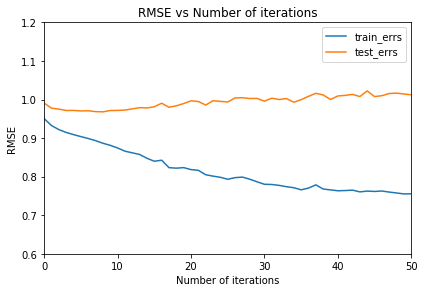

In [49]:
errs_df = pd.DataFrame({'n_itr' : np.arange(max_itr),'train_errs': train_errs, 'test_errs': test_errs})
fig, ax = plt.subplots()
errs_df['train_errs'].plot(style='-', ax=ax)
errs_df['test_errs'].plot(style='-', ax=ax)
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')
plt.ylim([0.6, 1.2])
plt.tight_layout()
plt.legend()
plt.title('RMSE vs Number of iterations')
# plt.savefig('SGD_itr.png', dpi=300)
plt.show()

In [40]:
# errs_df.to_csv(r'SGD_itr_results.csv', index = False, header = True)

SGD Algorithm is not stabable and might be sensetive with initial random values of parameters. For here, We use n_itr = 8 for finding optimal K values

## Find Optimal K

In [34]:
k_list = [1, 2, 5, 10, 20, 50, 100]
train_errs2 = np.zeros(len(k_list))
test_errs2 = np.zeros(len(k_list))

In [36]:
for i in range(len(k_list)):
    # initial model
    SGD_model = SGD(n_factors=k_list[i], n_itr=8, learning_rate=0.01, reg_bu=0.0, reg_bi=0.0,
                    reg_Pu=0.0, reg_Qi=0.0, bias_effect=True)
    SGD_model.fit(train_df)

    train_pred = SGD_model.predict(train_df)
    train_errs2[i] = RMSE(train_pred, train_df['rating'])

    test_pred = SGD_model.predict(test_df)
    test_errs2[i] = RMSE(test_pred, test_df['rating'])

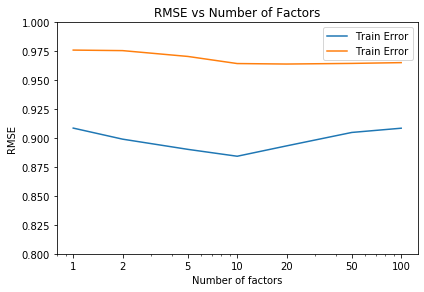

In [54]:
errs_df2 = pd.DataFrame({'n_factors' : k_list,'train_errs': train_errs2, 'test_errs': test_errs2})
fig, ax = plt.subplots()
l, = plt.semilogx(k_list, train_errs2, label='Train Error')
l, = plt.semilogx(k_list, test_errs2, label='Train Error')
plt.xlabel('Number of factors')
plt.ylabel('RMSE')
plt.xticks(k_list, k_list)
plt.ylim([0.8, 1])
plt.tight_layout()
plt.legend()
plt.title('RMSE vs Number of Factors')
plt.savefig('SGD_K.png', dpi=300)
plt.show()

In [38]:
errs_df2

,n_factors,train_errs,test_errs
0,1,0.908645,0.976071
1,2,0.899087,0.975610
2,5,0.890272,0.970577
3,10,0.884320,0.964431
4,20,0.893279,0.964014
5,50,0.904888,0.964560
6,100,0.908549,0.965226


In [43]:
# errs_df2.to_csv(r'SGD_k_results.csv', index = False, header = True)

The model achieve the best performance when we use 20 factors in our matrices given n_itr = 8.

## Use optimal values in Testset

In [48]:
final_model = SGD(n_factors=20, n_itr=8, learning_rate=0.01, reg_bu=0.0, reg_bi=0.0,
                    reg_Pu=0.0, reg_Qi=0.0, bias_effect=True)
final_model.fit(X_train)
RMSE(final_model.predict(X_test), X_test['rating'])

0.9608133523540203